In [1]:
%matplotlib inline

# scientific packages
import numpy as np
import scipy as sp
import pandas as pd
import patsy as pt
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import relativedelta
from geopy.distance import vincenty
from geopy.distance import great_circle
from pygeocoder import Geocoder
sns.set();

In [2]:
df = pd.read_csv('C:\\Users\\krish\\Downloads\\lyft\\train\\train.csv')
df.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
0,0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112
1,1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159
2,2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281
3,3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636
4,4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705


In [3]:
df.set_index('row_id')
df.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
0,0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112
1,1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159
2,2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281
3,3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636
4,4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705


In [4]:
for col in df:
    print (col, pd.isnull(df[col]).sum())

row_id 0
start_lng 0
start_lat 0
end_lng 0
end_lat 0
start_timestamp 0
duration 0


In [5]:
len(df['row_id'].unique())

12905715

In [6]:
df['start_lat'].describe()

count    12905715.000000
mean           40.750647
std             0.027897
min            40.368916
25%            40.736973
50%            40.753590
75%            40.767925
max            41.031418
Name: start_lat, dtype: float64

In [7]:
df['start_lng'].describe()

count    12905715.000000
mean          -73.973822
std             0.038003
min           -74.514618
25%           -73.992058
50%           -73.981956
75%           -73.967735
max           -73.414452
Name: start_lng, dtype: float64

In [8]:
df['end_lat'].describe()

count    12905715.000000
mean           40.751406
std             0.031921
min            40.368874
25%            40.735523
50%            40.754078
75%            40.769054
max            41.031509
Name: end_lat, dtype: float64

In [9]:
df['end_lng'].describe()

count    12905715.000000
mean          -73.973579
std             0.035899
min           -74.517853
25%           -73.991425
50%           -73.980087
75%           -73.963509
max           -73.414352
Name: end_lng, dtype: float64

# findings
    No Null values . 
    All data coming from a samll region ( std and range of lat long is small)

In [10]:
# To accomodate the dataset for the machine ,using sample of X(20) percent for further processing 

from random import sample
df_frac = df.sample(frac = 0.2) # set sample fraction
df = df_frac
del df_frac
len(df['row_id'].unique())

2581143

# Deriving new features

In [11]:
df["start_dts"] = pd.to_datetime(df["start_timestamp"], unit='s')
df.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,start_dts
9317837,9317837,-73.954384,40.815933,-73.952866,40.810638,1442669786,153,2015-09-19 13:36:26
1914969,1914969,-73.962456,40.767109,-73.973579,40.747761,1422831985,616,2015-02-01 23:06:25
2881492,2881492,-73.988182,40.737610,-73.978203,40.751400,1426651952,390,2015-03-18 04:12:32
10458772,10458772,-73.980667,40.730549,-73.975700,40.721939,1445308729,278,2015-10-20 02:38:49
3233518,3233518,-73.996628,40.763096,-73.986465,40.730244,1426916631,873,2015-03-21 05:43:51


In [12]:
df["start_month"] = df['start_dts'].dt.month
df["start_day_of_month"] = df['start_dts'].dt.day
df["start_day_of_week"] = df['start_dts'].dt.dayofweek
df["start_hour"] = df['start_dts'].dt.hour
df.head()


,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,start_dts,start_month,start_day_of_month,start_day_of_week,start_hour
9317837,9317837,-73.954384,40.815933,-73.952866,40.810638,1442669786,153,2015-09-19 13:36:26,9,19,5,13
1914969,1914969,-73.962456,40.767109,-73.973579,40.747761,1422831985,616,2015-02-01 23:06:25,2,1,6,23
2881492,2881492,-73.988182,40.737610,-73.978203,40.751400,1426651952,390,2015-03-18 04:12:32,3,18,2,4
10458772,10458772,-73.980667,40.730549,-73.975700,40.721939,1445308729,278,2015-10-20 02:38:49,10,20,1,2
3233518,3233518,-73.996628,40.763096,-73.986465,40.730244,1426916631,873,2015-03-21 05:43:51,3,21,5,5


In [13]:

def calc_distance (row):
    start_latlong = str(row["start_lat"]) + ',' + str(row["start_lng"])
    end_latlong = str(row["end_lat"]) + ',' + str(row["end_lng"])

    if (start_latlong == end_latlong):
        return 1 # Used 1 instead of 0 to aid log conversion
    else:
        return vincenty(start_latlong, end_latlong).meters # getting distance between start & end points in meters
    
df["dist_meters"] = df.apply(calc_distance, axis=1)
df["log_dist_meters"] = np.log(df['dist_meters'])
df["log_duration"] = np.log(df['duration'])

df.head()


,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,start_dts,start_month,start_day_of_month,start_day_of_week,start_hour,dist_meters,log_dist_meters,log_duration
9317837,9317837,-73.954384,40.815933,-73.952866,40.810638,1442669786,153,2015-09-19 13:36:26,9,19,5,13,601.798173,6.399922,5.030438
1914969,1914969,-73.962456,40.767109,-73.973579,40.747761,1422831985,616,2015-02-01 23:06:25,2,1,6,23,2344.910075,7.760002,6.423247
2881492,2881492,-73.988182,40.737610,-73.978203,40.751400,1426651952,390,2015-03-18 04:12:32,3,18,2,4,1747.976862,7.466214,5.966147
10458772,10458772,-73.980667,40.730549,-73.975700,40.721939,1445308729,278,2015-10-20 02:38:49,10,20,1,2,1044.158039,6.950966,5.627621
3233518,3233518,-73.996628,40.763096,-73.986465,40.730244,1426916631,873,2015-03-21 05:43:51,3,21,5,5,3747.794841,8.228923,6.771936


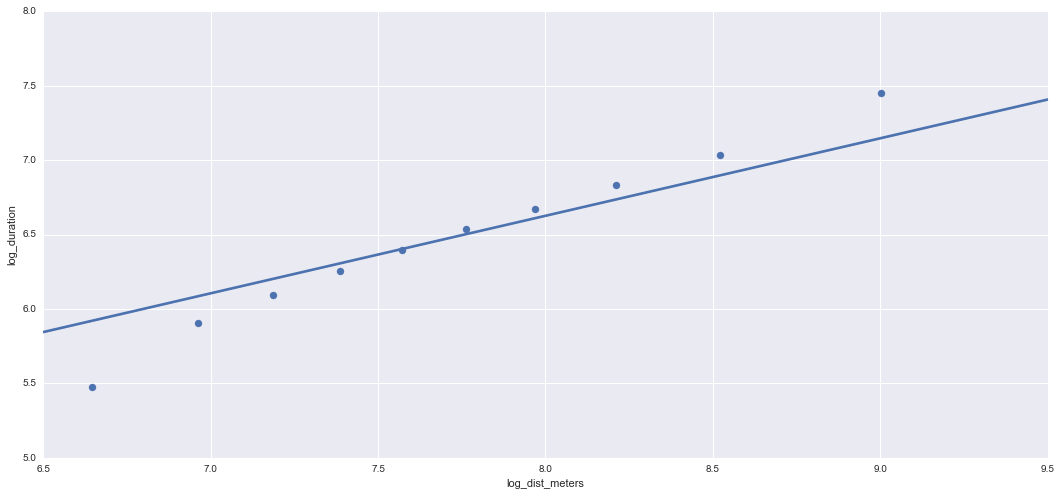

In [14]:
plt.figure(figsize=(18,8))
ax = sns.regplot(x="log_dist_meters", y="log_duration", data=df , x_bins=10)

In [15]:
sp.stats.pearsonr(df["log_dist_meters"], df["log_duration"])

(0.72675002899521313, 0.0)

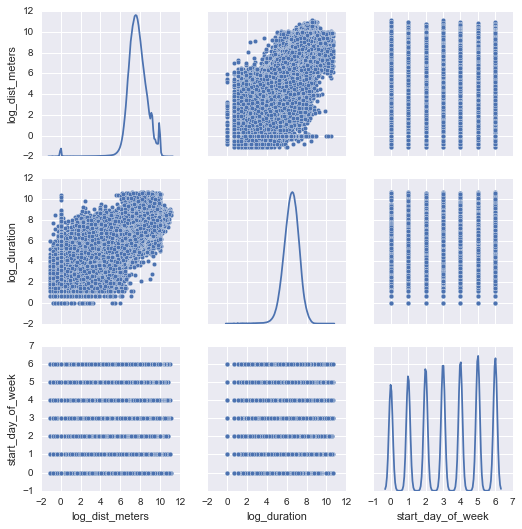

In [16]:
sns.pairplot(df,  vars=[ 'log_dist_meters', 'log_duration', 'start_day_of_week'], diag_kind='kde')

# findings 
    Strong correlation between log_duration and log_distance


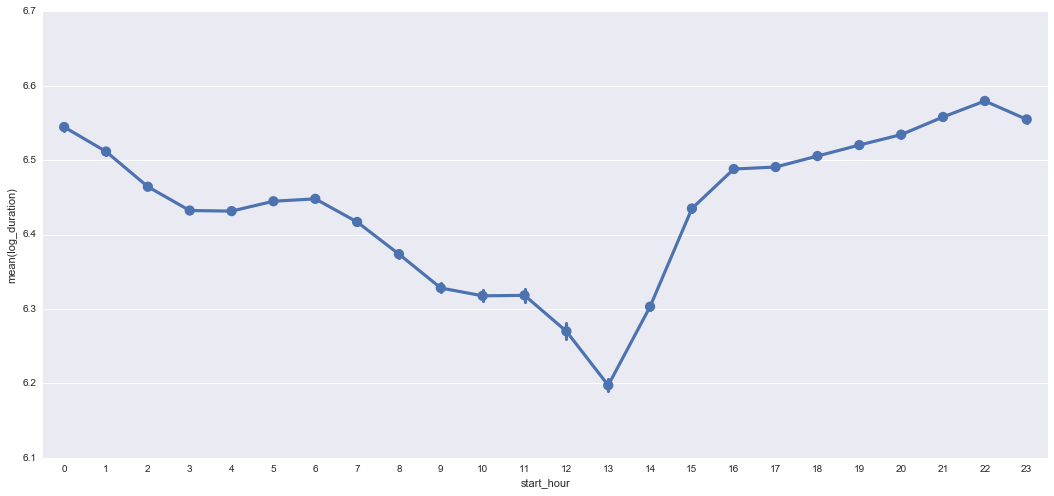

In [17]:
plt.figure(figsize=(18,8))
sns.pointplot(x="start_hour", y="log_duration", data=df);

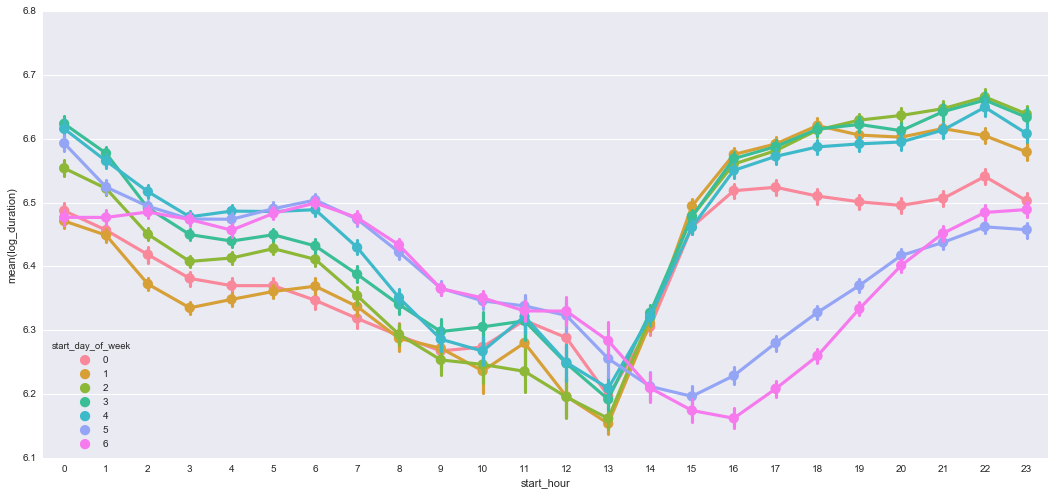

In [18]:
plt.figure(figsize=(18,8))
sns.pointplot(x="start_hour", y="log_duration", data=df, hue = "start_day_of_week");

# findings 
0  - Monday
6  - Sunday
    1) There is clear distinction in mean duration pattern between weekdays and weekends (around 15-20 hours). This may be due to less traffic during evening peak hours during weekends.
    2) Early morning duration is relatively high in latter part of the week compared to earlier part of the week. This may be due to usecases are different in weekends and friday ( like party compared to weekday).

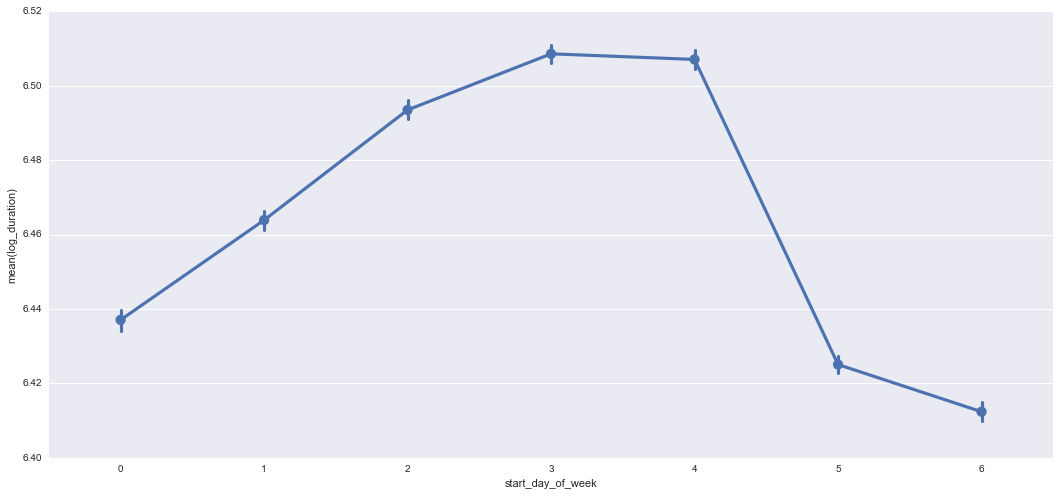

In [19]:
plt.figure(figsize=(18,8))
sns.pointplot(x="start_day_of_week", y="log_duration", data=df);

# findings
    1) There is clear distinction in mean duration pattern between weekdays and weekends. This may be due to less traffic during evening peak hours during weekends.
    

# dummy variables

In [20]:
df.columns

Index(['row_id', 'start_lng', 'start_lat', 'end_lng', 'end_lat',
       'start_timestamp', 'duration', 'start_dts', 'start_month',
       'start_day_of_month', 'start_day_of_week', 'start_hour', 'dist_meters',
       'log_dist_meters', 'log_duration'],
      dtype='object')

In [21]:
features = [#'dist_meters',
            'log_dist_meters',
            'start_lat',
            'start_lng',
            'end_lat',
            'end_lng'
           ]

categoricals = ['start_month',
                'start_day_of_month',
                'start_day_of_week',
                'start_hour'
               ]

target = 'log_duration'
# target = 'duration'

In [22]:
dummy_categoricals = []
for categorical in categoricals:
    print (categorical, len(df[categorical].unique()))
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    df = pd.concat([df, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

start_month 12
start_day_of_month 31
start_day_of_week 7
start_hour 24


In [23]:
len(dummy_categoricals)

70

In [24]:
feature_names = features + dummy_categoricals
feature_names

['log_dist_meters',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'start_month_1',
 'start_month_2',
 'start_month_3',
 'start_month_4',
 'start_month_5',
 'start_month_6',
 'start_month_7',
 'start_month_8',
 'start_month_9',
 'start_month_10',
 'start_month_11',
 'start_day_of_month_1',
 'start_day_of_month_2',
 'start_day_of_month_3',
 'start_day_of_month_4',
 'start_day_of_month_5',
 'start_day_of_month_6',
 'start_day_of_month_7',
 'start_day_of_month_8',
 'start_day_of_month_9',
 'start_day_of_month_10',
 'start_day_of_month_11',
 'start_day_of_month_12',
 'start_day_of_month_13',
 'start_day_of_month_14',
 'start_day_of_month_15',
 'start_day_of_month_16',
 'start_day_of_month_17',
 'start_day_of_month_18',
 'start_day_of_month_19',
 'start_day_of_month_20',
 'start_day_of_month_21',
 'start_day_of_month_22',
 'start_day_of_month_23',
 'start_day_of_month_24',
 'start_day_of_month_25',
 'start_day_of_month_26',
 'start_day_of_month_27',
 'start_day_of_month_28',
 'start_d

# Model Building

In [25]:
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

In [44]:
# df_frac = df.sample(frac = 0.2) # set sample fraction
# df_all = df
# df = df_frac
# del df_frac
# len(df['row_id'].unique())

In [36]:
train, test = train_test_split(df, test_size=0.4)

# Gradient Boost Regressor

In [43]:
params = {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 1,'learning_rate': 0.1, 'loss': 'ls'}
gb_regr = ensemble.GradientBoostingRegressor(**params)
gb_regr.fit(train[feature_names], train[target])
predicted = gb_regr.predict(test[feature_names])
mean_squared_error(test[target], predicted)

In [ ]:
exp_predicted = np.exp(predicted)
mean_squared_error(test['duration'], exp_predicted)

In [ ]:
gb_importances = pd.DataFrame({'name':train[feature_names].columns,
                               'importance':gb_regr.feature_importances_
                              }).sort_values(by='importance', ascending=False).reset_index(drop=True)
gb_importances.head(20)

# Random Forest Regressor

In [38]:
rf_regr = RandomForestRegressor(n_estimators=200)
rf_regr.fit(train[feature_names], train[target])
predicted = rf_regr.predict(test[feature_names])
mean_squared_error(test[target], predicted)

0.17693019188218001

In [39]:
exp_predicted = np.exp(predicted)
mean_squared_error(test['duration'], exp_predicted)

193664.010408136

In [40]:
rf_importances = pd.DataFrame({'name':train[feature_names].columns,
                               'importance':rf_regr.feature_importances_
                              }).sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_importances.head(20)

,importance,name
0,0.660318,log_dist_meters
1,0.057877,end_lat
2,0.044988,end_lng
3,0.043851,start_lng
4,0.039292,start_lat
5,0.004938,start_hour_13
6,0.004085,start_hour_12
7,0.003862,start_day_of_week_5
8,0.003856,start_day_of_week_0
9,0.003504,start_hour_7


# findings

    1) Gradient boosting regressor (Boosting approach)
        - Best performance for this dataset
        - Ensemble methods are always result in better performance most of the time.
        
    2) Random forest regressor (Bagging approach)
        - Second Best performance for this dataset 
        - Ensemble methods are always result in better performance most of the time.
        - Size of dataset id relatively huge - so random forest can be easily distributed.
        - No missing values in the dataset

    

# Testing

In [ ]:
df_test = pd.read_csv('C:\\Users\\krish\\Downloads\\lyft\\test\\test.csv')
df_test.set_index('row_id')
df_test["start_dts"] = pd.to_datetime(df_test["start_timestamp"], unit='s')
df_test["start_year"] = df_test['start_dts'].dt.year
df_test["start_month"] = df_test['start_dts'].dt.month
df_test["start_day_of_month"] = df_test['start_dts'].dt.day
df_test["start_day_of_week"] = df_test['start_dts'].dt.dayofweek
df_test["start_hour"] = df_test['start_dts'].dt.hour

df_test["start_latlong"] = df_test[['start_lat', 'start_lng']]\
    .apply(lambda x: ','.join(str(value) for value in x), axis=1)
df_test["end_latlong"] = df_test[['end_lat', 'end_lng']]\
    .apply(lambda x: ','.join(str(value) for value in x), axis=1)
    
df.head()

In [ ]:
def calc_distance (row):
    if (row["start_latlong"] == row["end_latlong"]):
        return 1
    else:
        return vincenty(row["start_latlong"], row["end_latlong"]).meters

df_test["dist_meters"] = df_test.apply(calc_distance, axis=1)
df_test["log_dist_meters"] = np.log(df_test['dist_meters'])

df_test.drop('start_latlong', axis=1, inplace=True)
df_test.drop('end_latlong', axis=1, inplace=True)
df_test.head()

In [ ]:
for categorical in categoricals:
    print (categorical, len(df_test[categorical].unique()))
    drop_var = sorted(df_test[categorical].unique())[-1]
    temp_df = pd.get_dummies(df_test[categorical], prefix=categorical)
    df_test = pd.concat([df_test, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

In [ ]:
log_predicted = gb_regr.predict(df_test[feature_names])

In [ ]:
test_res = df_test['row_id'] + np.exp(log_predicted)
test_res.columns=["row_id", "duration"]
test_res.to_csv('C:\\Users\\krish\\Downloads\\lyft\\duration_act.csv', sep=',')

# Additional improvements
    1) Here geo lat long belongs to closed area (SD is small in describe). In case of developing a predictive model for wide geographical area, clustering of geo lat long like county,city, state, street etc will help in better prediction.
    
    2) Including signals like holidays, local events, festivals to geo may help in better duration prediction.
    
    3) Including traffic patterns , construction, accident, weather signals will also help in better prediction.
    
    